# Bayesian neural network in pyro
Here, I implemented the BNN method to model data from DEM aggregation

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

file_path = '/content/NPaggdata_st.txt'
data = np.loadtxt(file_path)

# Separate features (X_train) and labels (Y_train)
X = data[:, :-1]  # All columns except the last one
#varying_columns = np.where(X.std(axis=0) > 0)[0]
#zp_dom zp_nc zp A_np A_dom A_nc rho_ps rho_dom rho_nc Xdomi gamma_np gamma_nc gamma_dom ...

varying_columns = [3,  5,  6,  7,  9, 10, 18, 20, 21,
       22]

#for np+np collision only:
#varying_columns = [3, 4,  5,  6,  7,  8,  9, 10, 11, 14, 18, 19, 20, 21,22]
#3: zp_dom  0
#5: zp      1
#6: A_np    2
#7: A_dom   3
#9: rho_ps  4
#10: rho_dom5
#18: g_np   6
#20: g_dom  7
#21: np's   8
#22: dom's  9

# Select only varying columns
#X_varying = X;
X_varying = X[:, varying_columns]
X_varying[:,2] = np.log(X_varying[:,2]); X_varying[:,3] = np.log(X_varying[:,3]);# X_varying[:,5] = np.log(X_varying[:,5]);
y = data[:, -1]   # Last column
y = np.where(y == 0, -1, y)
#X, y = load_boston(return_X_y=True)
scaler = StandardScaler()
#scaled_data = scaler.fit_transform(data)
X_varying = scaler.fit_transform(X_varying)
#X_varying[:,1] = 0;
#X_varying[:,5] = 0;
#X_varying[:,10] = 0;

y = np.expand_dims(y, -1);#StandardScaler().fit_transform(np.expand_dims(y, -1))

X_train, X_test, y_train, y_test = train_test_split(X_varying,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42)


X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()



In [ ]:
abs(X_varying[:,2])

array([1.356729  , 1.23808265, 1.59598758, ..., 0.79070143, 0.61174884,
       0.81987137])

# 2. Model

In [4]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 4.2 MB/s eta 0:00:00


In [5]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
import torch
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

In [6]:
class Model(PyroModule):

    def __init__(self, input_dim = 10, h1=10, h2=4):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](input_dim, h1)
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([h1, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 1.).expand([h1]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([h2, h1]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 1.).expand([h2]).to_event(1))
        self.fc3 = PyroModule[nn.Linear](h2, 2)
        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([2, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0., 1.).expand([2]).to_event(1))
        self.fc4 = PyroModule[nn.Linear](2, 1)
        self.fc4.weight = PyroSample(dist.Normal(0., 1.).expand([1, 2]).to_event(2))
        self.fc4.bias = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        x = x.reshape(-1, self.fc1.weight.shape[1])
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
#         mu = self.relu(self.fc3(x).squeeze())
#         sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
#         with pyro.plate("data", x.shape[0]):
#             obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
#         return mu
        mu = (torch.tanh(self.fc4(x))).squeeze()  # Remove the ReLU activation here
        #mu = self.relu(mu)  # Apply ReLU activation to ensure mu >= 0
        sigma = pyro.sample("sigma", dist.Uniform(0., 1));
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
#             binary_obs = torch.bernoulli(0.5 + 0.5 * torch.sign(mu)).long()  # 1 if > 0, -1 if <= 0
#             # Use the binary values to create observations
#             obs = binary_obs * 2 - 1  # Map 0 to -1 and 1 to 1
#             # If y is provided, use it as observations
#             if y is not None:
#                 obs = y
#             pyro.sample("obs", dist.Delta(obs), obs=y)
        return mu


# 3. Training

  0%|          | 0/2000 [00:00<?, ?it/s]

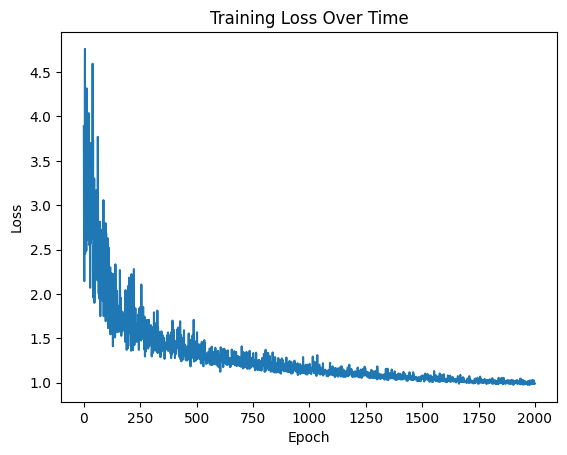

In [8]:
import matplotlib.pyplot as plt
model = Model()
#guide = AutoDiagonalNormal(model)
guide = AutoMultivariateNormal(model)
adam = pyro.optim.Adam({"lr": 1e-3})
svi = SVI(model, guide, adam, loss=Trace_ELBO())
losses = []

pyro.clear_param_store()
bar = trange(20000)
#x_train = torch.from_numpy(x).float()
#y_train = torch.from_numpy(y).float()
for epoch in bar:
    loss = svi.step(X_train, y_train.squeeze())
    losses.append(loss / X_train.shape[0])
    bar.set_postfix(loss=f'{loss / X.shape[0]:.3f}')
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()
    #print(f'{loss / x.shape[0]:.3f}')

In [9]:
names = [r'$\zeta_{DOM}$ (mV)', r'$\zeta_{NP}$ (mV)', r'$A_{np}$ (J)', r'$A_{DOM}$ (J)', r'$\rho_{NP} (kg/m^{3})$ ', r'$\rho_{DOM} (kg/m^{3})$',r'$\gamma_{NP} (mJ/m^{2})$', r'$\gamma_{DOM} (mJ/m^{2})$', r'$num_{NP}$', r'$num_{DOM}$']
names_raw = [r'zeta_DOM', r'zeta_NP', r'A_NP', r'A_DOM', r'rho_NP', r'rho_DOM',r'gamma_NP', r'gamma_DOM', r'num_NP', r'num_DOM']
#names = ['zp_dom','zp_nc', 'zp', 'A_np', 'A_dom', 'A_nc', 'rho_np', 'rho_dom', 'rho_nc','g_np', 'g_nc', 'g_dom', 'num_np', 'num_dom', 'num_attached_np']

In [10]:
import torch

predictive = Predictive(model, guide=guide, num_samples=500)
#x_test = torch.linspace(-0.5, 1, 3000)
preds = predictive(X_train)

y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)

# Assuming your model, guide, and SVI are already defined and trained
# X_train and y_train are your training data and labels

# Set the model and guide to evaluation mode
model.eval()
guide.eval()

# Number of samples to draw from the posterior predictive distribution
num_samples = 1

# Initialize variables to store predictions and true labels
all_predictions = []
true_labels =[]
all_predictions_arr = []
# Use a loop to draw samples and make predictions
with torch.no_grad():
    for _ in range(num_samples):
        print(_)
        # Sample from the posterior predictive distribution
        sampled_model = guide()
        #y_pred1 = model.forward(X_train)
        preds = predictive(X_train)
        y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
        # Store predictions and true labels
        all_predictions.append(y_pred)
        true_labels.append(y_train)
        all_predictions_arr.append(preds['obs'].T.detach().numpy()>0)
# Calculate the mean prediction across all samples
mean_predictions = all_predictions; #np.mean(all_predictions, axis=0)

# Convert predictions to binary (assuming binary classification)
binary_predictions = (mean_predictions[0] > 0).astype(int)
true_labels_binary = ((true_labels[0]>0).numpy()).astype(int)
# Calculate accuracy
accuracy = np.mean(binary_predictions == true_labels_binary)
print(f'Training Accuracy: {accuracy * 100:.2f}%')


0
Training Accuracy: 79.12%


In [ ]:
def negative_log_likelihood(y_true, predicted_probs):
    return -np.mean(np.log(np.maximum(predicted_probs, 1e-12)))
def expected_calibration_error(y_true, predicted_probs, num_bins=10):
    confidences, accuracies = calibration_curve(y_true, predicted_probs, n_bins=num_bins)
    ece = np.sum((confidences - accuracies) * (1 / num_bins))
    return ece
def log_likelihood(y_true, predicted_probs):
    return np.mean(np.log(np.maximum(predicted_probs[np.arange(len(y_true)), y_true], 1e-12)))
def brier_score(y_true, predicted_probs):
    return np.mean(np.sum((predicted_probs - (y_true == np.arange(predicted_probs.shape[1]))[:, None])**2, axis=1))

#negative_log_likelihood(true_labels_binary, all_predictions_arr[0])
print(brier_score(true_labels_binary, all_predictions_arr[0]*1))

In [ ]:
import torch

# Assuming your model and guide are already defined and trained

# Save the model and guide parameters
torch.save({
    'model_state_dict': model.state_dict(),
    'guide_state_dict': guide.state_dict(),
}, '/content/sample_data/your_saved_model2.pth')


# 4. Prediction

In [11]:
predictive = Predictive(model, guide=guide, num_samples=500)
#x_test = torch.linspace(-0.5, 1, 3000)
preds = predictive(X_train)

y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
y_std = preds['obs'].T.detach().numpy().std(axis=1)

X_play = torch.tensor([-0.3304, -0.0749,
                       0, 0,
                       0, 0,
                        0, 0,
                       -0.2562,  0.5114]);
X_play = torch.tensor(np.median(X_train[:],0));   X_play[9] =2.5112512; X_play[1] = 1.8;  X_play[0] = -0.79;
scaler.inverse_transform(X_play.reshape(1, -1))

paramv0 = scaler.inverse_transform(X_play.reshape(1, -1))
print(names)
print(paramv0)

['$\\zeta_{DOM}$ (mV)', '$\\zeta_{NP}$ (mV)', '$A_{np}$ (J)', '$A_{DOM}$ (J)', '$\\rho_{NP} (kg/m^{3})$ ', '$\\rho_{DOM} (kg/m^{3})$', '$\\gamma_{NP} (mJ/m^{2})$', '$\\gamma_{DOM} (mJ/m^{2})$', '$num_{NP}$', '$num_{DOM}$']
[[-3.88722168e-02  4.04408140e-02 -4.56384174e+01 -4.54098480e+01
   1.72051300e+03  1.38717900e+03  2.55000000e-02  2.55000000e-02
   1.00000000e+00  1.70000004e+01]]


In [ ]:
from statsmodels.stats.proportion import proportion_confint
pred_mat = np.zeros([17,10]);
pred_mat2 = np.zeros([17,10]);
pred_mat2_std = np.zeros([17,10]);
pred_mat2_low = np.zeros([17,10]);
pred_mat2_high = np.zeros([17,10]);
parameter_val = np.zeros([17,10]);
#X_play = torch.tensor([-1.085, -1.085, 1.01, 0, 0, 0, 0, 0, 0, 0,0, 0, 0,  0.1,  0,  0,  0]);
#X_play = torch.tensor([-1.085, -1.085, +1.01, 0, 0, 0, 0, 0, 0,-0.4, 0, 0,  0,  -1,  0]);
#X_play = torch.tensor([-1.085, -1.085, 0.1, 0, 0, 0, 0, 0, 0, 0,-0.4, 0, 0,  0.0,  -0.663]);
arrayv = np.linspace(-2.2,2.2,10)
for j in range(10):
  print(j);
  arrayv = np.linspace(min(X_train[:,j]),max(X_train[:,j]),10);
  for i in range(10):
     X_play2 = X_play.clone();
     X_play2[j] = arrayv[i];
     paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
     preds1 = predictive(X_play2)
     y_pred1 = (preds1['obs']>0).detach().numpy()*1;
     #pred_mat[j,i] = y_pred1;
     pred_mat2[j,i] = np.mean(y_pred1);#(sum(preds1['obs']>0)/len(preds1['obs'])).detach().numpy()
     ci_low, ci_upp = proportion_confint(sum(y_pred1), len(y_pred1), alpha=0.01, method='wilson')
     pred_mat2_low[j,i] = ci_low;
     pred_mat2_high[j,i] = ci_upp;
     #pred_mat2_std[j,i] = np.std((preds1['obs']>0).detach().numpy())
     if j == 2 or j ==3:
         parameter_val[j,i] = np.exp(paramv[0][j]);
     elif j== 8 or j==9 or j==4 or j==5:
         parameter_val[j,i] = paramv[0][j];
     else:
         parameter_val[j,i] = paramv[0][j]*1000;

import os
import shutil

output_folder = f"/content/sample_data/npnp_agg_st_DOM={X_play[9]}"
if not os.path.exists(output_folder):
        os.makedirs(output_folder)
np.savetxt(f'{output_folder}/pred_mat3_npnp_agg_st_DOM={X_play[9]}.txt', pred_mat2)
np.savetxt(f'{output_folder}/pred_mat3_low_npnp_agg_st_DOM={X_play[9]}.txt', pred_mat2_low)
np.savetxt(f'{output_folder}/pred_mat3_high_npnp_agg_st_DOM={X_play[9]}.txt', pred_mat2_high)
np.savetxt(f'{output_folder}/parameter_val_npnp_agg_st_DOM={X_play[9]}.txt', parameter_val)
shutil.make_archive(output_folder, 'zip', output_folder)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


'/content/sample_data/npnc_agg_st_DOM=-1.3562449216842651.zip'

In [ ]:
import os
import shutil
output_folder = f"/content/sample_data/npnc_agg_st_DOM={X_play[13]}"
if not os.path.exists(output_folder):
        os.makedirs(output_folder)
np.savetxt(f'{output_folder}/pred_mat3_npnc_agg_st_DOM={X_play[13]}.txt', pred_mat2)
np.savetxt(f'{output_folder}/pred_mat3_low_npnc_agg_st_DOM={X_play[13]}.txt', pred_mat2_low)
np.savetxt(f'{output_folder}/pred_mat3_high_npnc_agg_st_DOM={X_play[13]}.txt', pred_mat2_high)
np.savetxt(f'{output_folder}/parameter_val_npnc_agg_st_DOM={X_play[13]}.txt', parameter_val)
shutil.make_archive(output_folder, 'zip', output_folder)

'/content/sample_data/npnc_agg_st_DOM=-1.177520751953125.zip'

0
1
2
3
4
5
6
7
8
9
(60, 40)
(60, 40)
(60, 40)


<ipython-input-130-9d8c74ee61fe>:72: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-130-9d8c74ee61fe>:73: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
<ipython-input-130-9d8c74ee61fe>:74: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


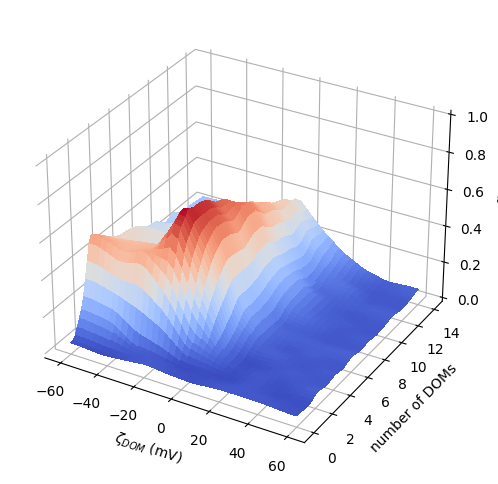

(60, 40)
(60, 40)
(60, 40)


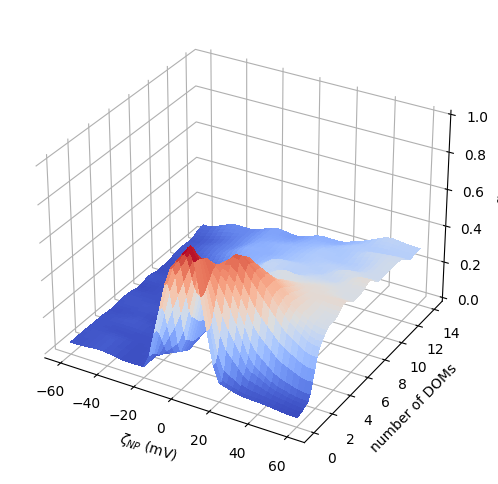

(60, 40)
(60, 40)
(60, 40)


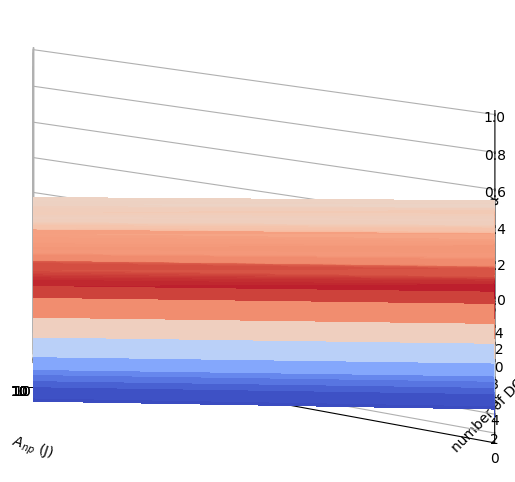

(60, 40)
(60, 40)
(60, 40)


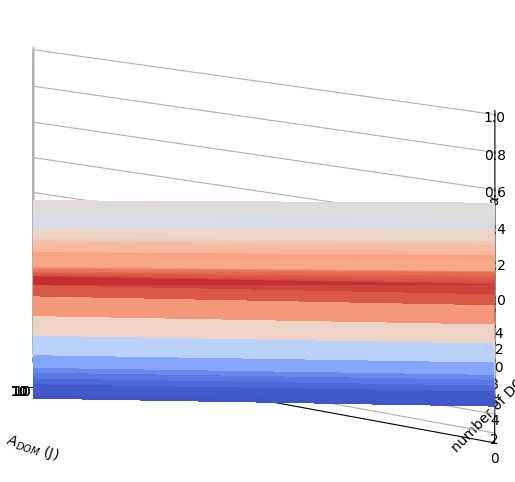

(60, 40)
(60, 40)
(60, 40)


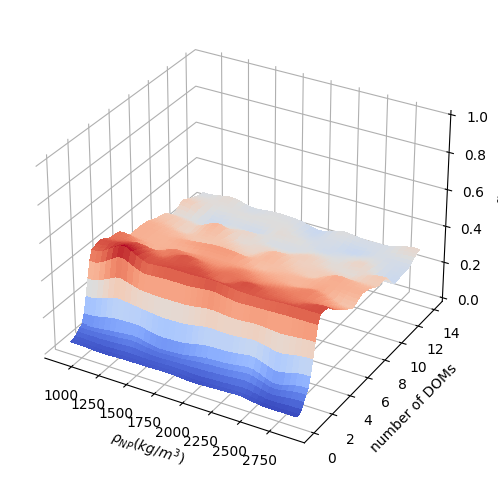

(60, 40)
(60, 40)
(60, 40)


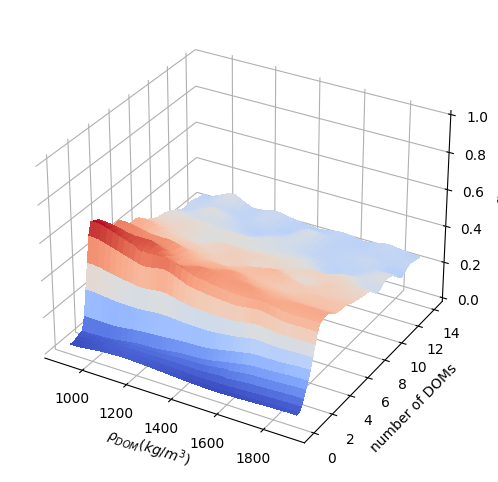

(60, 40)
(60, 40)
(60, 40)


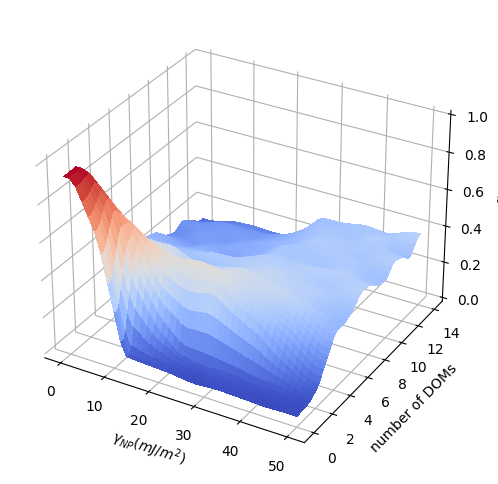

(60, 40)
(60, 40)
(60, 40)


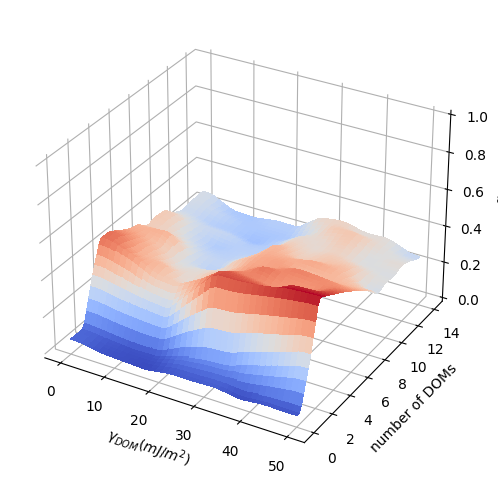

(60, 40)
(60, 40)
(60, 40)


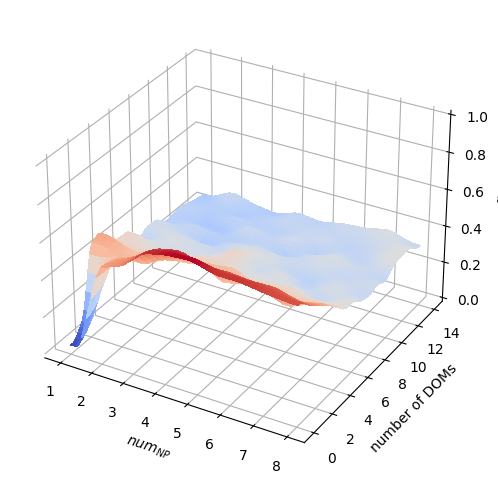

(60, 40)
(60, 40)
(60, 40)


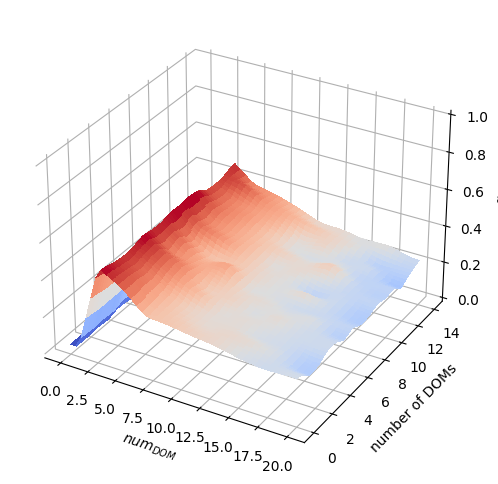

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import shutil
import zipfile
import cv2

parameter_val = np.zeros([10,40])
array_dom = np.linspace(-6.6289e-01,5.1692,10)
for j in range(10):
  print(j);
  arrayv = np.linspace(min(X_train[:,j]),max(X_train[:,j]),40);
  for i in range(40):
     X_play2 = X_play.clone();
     X_play2[j] = arrayv[i];
     #for k in range(10):
     #X_play2[9] = array_dom[k];
     paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
     parameter_val[j,i] = paramv[0][j];

DOM_list = np.loadtxt('/content/DOM_list.txt')
DOM_list

pred_mat3 = np.zeros([17,len(DOM_list),10]);
pred_mat3_std = np.zeros([17,len(DOM_list),10]);
pred_mat3_low = np.zeros([17,len(DOM_list),10]);
pred_mat3_high = np.zeros([17,len(DOM_list),10]);
#parameter_val = np.zeros([17,10]);
for kj in range(len(DOM_list)):
  p1 = np.loadtxt(f'/content/sample_data/npnp_agg_st_DOM={DOM_list[kj]}/pred_mat3_npnp_agg_st_DOM={DOM_list[kj]}.txt');
  p1_low = np.loadtxt(f'/content/sample_data/npnp_agg_st_DOM={DOM_list[kj]}/pred_mat3_low_npnp_agg_st_DOM={DOM_list[kj]}.txt');
  p1_high = np.loadtxt(f'/content/sample_data/npnp_agg_st_DOM={DOM_list[kj]}/pred_mat3_high_npnp_agg_st_DOM={DOM_list[kj]}.txt');

  for i in range(17):
    for j in range(10):
     # for k in range(len(DOM_list)):
      pred_mat3[i,kj,j] = p1[i,j];
      pred_mat3_low[i,kj,j] = p1_low[i,j];
      pred_mat3_high[i,kj,j] = p1_high[i,j];


parameter_val[0,:] = parameter_val[0,:]*1000;
parameter_val[1,:] = parameter_val[1,:]*1000;
parameter_val[2,:] = np.exp(parameter_val[2,:]);
parameter_val[3,:] = np.exp(parameter_val[3,:]);
parameter_val[6,:] = parameter_val[6,:]*1000;
parameter_val[7,:] = parameter_val[7,:]*1000;

def plot_3d_subplots(data, data_low, data_high, names, names_raw, parameter_val,  lower_lims, upper_lims):
 output_folder = "/content/NPNPagg_st"
 if not os.path.exists(output_folder):
        os.makedirs(output_folder)

 for i, (array, array_low, array_high, name, value) in enumerate(zip(data, data_low, data_high, names, parameter_val)):
        # Create a new figure for each subplot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        value2 = np.linspace(value[0],value[-1],40);
        # Create a meshgrid for the 10x10 array
        y, x = np.meshgrid(np.transpose(value), np.linspace(0,14,60));

        arr =  cv2.resize(array, (40, 60), interpolation=cv2.INTER_LINEAR)
        print(arr.shape)
        print(x.shape)
        print(y.shape)
        # Plot the 3D surface
        ax.plot_surface(y,x,(arr), cmap=cm.coolwarm, edgecolor='none',  antialiased=False, rcount=10000, ccount=10000)
        ax.set_zlim(0, 1)

        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.set_xlabel(name)
        ax.set_ylabel('number of DOMs')
        ax.set_zlabel(r'$\alpha$')
        #ax.set_xlim(value[0], value[39])
        #ax.set_xlim(lower_lims[i], upper_lims[i])
        if i==2 or i==3:
            ax.set_xscale('log')
        # Save each individual figure with extended bbox
        #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        #pad_inches_x = -0.3  # Adjust the padding to the right
        #pad_inches_y = -0.6  # Adjust the padding down
        #extent.x0 += pad_inches_x
        #extent.y0 += -0.5
        #extent.x1 += 0.52
        #extent.y1 += 0
        file_path = os.path.join(output_folder, f'NPNPagg_{names_raw[i]}_st.png')
        fig.savefig(file_path)
        #fig.savefig(f'NPNPagg_{names_raw[i]}.png')

        # Close the figure to release resources
        plt.show()
        plt.close(fig)
 shutil.make_archive(output_folder, 'zip', output_folder)
    # Show the plot (optional)


# Example usage:
# Replace the following with your actual data


# Call the function
lower_lims = [-50,-50, 5e-21, 5e-21, 1050, 800, 0, 0,1,0]
upper_lims = [50,50, 8e-20, 8e-20, 1700, 2000, 50, 50,1,12]
#names = ['zp_dom', 'zp', 'A_np', 'A_dom', 'rho_np', 'rho_dom','g_np', 'g_dom', 'num_np', 'num_dom']
names = [r'$\zeta_{DOM}$ (mV)', r'$\zeta_{NP}$ (mV)', r'$A_{np}$ (J)', r'$A_{DOM}$ (J)', r'$\rho_{NP} (kg/m^{3})$ ', r'$\rho_{DOM} (kg/m^{3})$',r'$\gamma_{NP} (mJ/m^{2})$', r'$\gamma_{DOM} (mJ/m^{2})$', r'$num_{NP}$', r'$num_{DOM}$']
names_raw = [r'zeta_DOM', r'zeta_NP', r'A_NP', r'A_DOM', r'rho_NP', r'rho_DOM',r'gamma_NP', r'gamma_DOM', r'num_NP', r'num_DOM']
plot_3d_subplots(pred_mat3, pred_mat3_low, pred_mat3_high, names, names_raw,parameter_val, lower_lims, upper_lims)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import shutil
import zipfile

parameter_val = np.zeros([17,20]);
array_dom = np.linspace(-6.6289e-01,5.1692,20)
for j in range(10):
  print(j);
  arrayv = np.linspace(min(X_train[:,j]),max(X_train[:,j]),20);
  for i in range(20):
     X_play2 = X_play.clone();
     X_play2[j] = arrayv[i];
     for k in range(20):
        X_play2[9] = array_dom[k];
        paramv = scaler.inverse_transform(X_play2.reshape(1, -1))
        parameter_val[j,i] = paramv[0][j];


parameter_val[0,:] = parameter_val[0,:]*1000;
parameter_val[1,:] = parameter_val[1,:]*1000;
parameter_val[2,:] = np.exp(parameter_val[2,:]);
parameter_val[3,:] = np.exp(parameter_val[3,:]);
parameter_val[6,:] = parameter_val[6,:]*1000;
parameter_val[7,:] = parameter_val[7,:]*1000;

def plot_3d_subplots(data, data_low, data_high, names, names_raw, parameter_val,  lower_lims, upper_lims):
 output_folder = "/kaggle/working/NPNPagg"
 if not os.path.exists(output_folder):
        os.makedirs(output_folder)

 for i, (array, array_low, array_high, name, value) in enumerate(zip(data, data_low, data_high, names, parameter_val)):
        # Create a new figure for each subplot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Create a meshgrid for the 10x10 array
        x, y = np.meshgrid(value, np.linspace(0,14,20))
        print(value)
        # Plot the 3D surface
        ax.plot_surface(x, y, array, cmap=cm.coolwarm, edgecolor='none',  antialiased=False, rcount=2000, ccount=2000)
        ax.set_zlim(0, 1)

        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.set_xlabel(name)
        ax.set_ylabel('number of DOMs')
        ax.set_zlabel(r'$\alpha$')
        #ax.set_xlim(lower_lims[i], upper_lims[i])
        if i==2 or i==3:
            ax.set_xscale('log')
        # Save each individual figure with extended bbox
        #extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        #pad_inches_x = -0.3  # Adjust the padding to the right
        #pad_inches_y = -0.6  # Adjust the padding down
        #extent.x0 += pad_inches_x
        #extent.y0 += -0.5
        #extent.x1 += 0.52
        #extent.y1 += 0
        file_path = os.path.join(output_folder, f'NPNPagg_{names_raw[i]}.png')
        fig.savefig(file_path)
        #fig.savefig(f'NPNPagg_{names_raw[i]}.png')

        # Close the figure to release resources
        plt.show()
        plt.close(fig)
 shutil.make_archive(output_folder, 'zip', output_folder)
    # Show the plot (optional)


# Example usage:
# Replace the following with your actual data


# Call the function
lower_lims = [-50,-50, 5e-21, 5e-21, 1050, 800, 0, 0,1,0]
upper_lims = [50,50, 8e-20, 8e-20, 1700, 2000, 50, 50,1,12]
#names = ['zp_dom', 'zp', 'A_np', 'A_dom', 'rho_np', 'rho_dom','g_np', 'g_dom', 'num_np', 'num_dom']
names = [r'$\zeta_{DOM}$ (mV)', r'$\zeta_{NP}$ (mV)', r'$A_{np}$ (J)', r'$A_{DOM}$ (J)', r'$\rho_{NP} (kg/m^{3})$ ', r'$\rho_{DOM} (kg/m^{3})$',r'$\gamma_{NP} (mJ/m^{2})$', r'$\gamma_{DOM} (mJ/m^{2})$', r'$num_{NP}$', r'$num_{DOM}$']
names_raw = [r'zeta_DOM', r'zeta_NP', r'A_NP', r'A_DOM', r'rho_NP', r'rho_DOM',r'gamma_NP', r'gamma_DOM', r'num_NP', r'num_DOM']
plot_3d_subplots(pred_mat3, pred_mat3_low, pred_mat3_high, names, names_raw,parameter_val, lower_lims, upper_lims)


In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.8 MB/s eta 0:00:00


In [ ]:
import shap
explainer = shap.Explainer(model, guide, device="cuda" if torch.cuda.is_available() else "cpu")

# Create a dummy dataset for explanation
num_samples = 100
dummy_data = torch.randn(num_samples, 10)

# Compute SHAP values for the dummy data
shap_values = explainer.shap_values(dummy_data)

# Plot summary plot
shap.summary_plot(shap_values, dummy_data, feature_names=names;#[f"Feature {i}" for i in range(input_size)])

SyntaxError: invalid syntax (<ipython-input-13-25d6f8d9fa9e>, line 12)

In [ ]:
print((model_predict(X_train.detach().numpy())))
print((X_train.T.detach().numpy()).dtype)

In [ ]:
len(names)

15

ExactExplainer explainer: 101it [21:14, 12.75s/it]


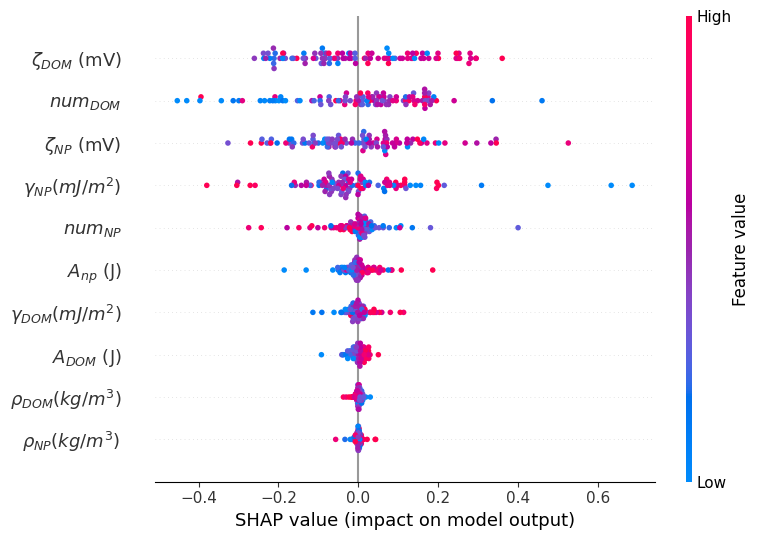

In [ ]:
#explainer = shap.Explainer(model, X_train)
import shap
from shap import ExactExplainer
num_samples = 100
import shap
def model_predict(X_test):
    X_test1 = torch.Tensor(X_test).float()
    predictive = Predictive(model, guide=guide, num_samples=500)
    #x_test = torch.linspace(-0.5, 1, 3000)
    pred = predictive(X_test1)
    val = torch.Tensor(pred['obs'].detach().numpy().mean(axis=0))
    #val.dtype = torch.float64;
    return val


# Create a KernelExplainer
#dummy_data = torch.randn(num_samples, 10)
#explainer = shap.Explainer(model_predict, dummy_data.detach().numpy())
dummy_data = torch.randn(num_samples, 10)
explainer = ExactExplainer(model_predict, dummy_data.detach().numpy())

# Compute SHAP values
#shap_values = explainer.shap_values(dummy_data.detach().numpy())
#
shap_values = explainer(dummy_data.detach().numpy())


# Compute SHAP values for the dummy data
#shap_values = explainer.shap_values(X_train)

# Plot summary plot
shap.summary_plot(shap_values, dummy_data, feature_names=[feature for feature in names])